### Initializing Credentials

### Creating Reddit Object

In [36]:
import praw

In [37]:
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=SECRET_KEY,
    user_agent="MyAPI/0.0.1",
    username=UNAME,
    password=PWD
)

### Collecting text data from Reddit posts

In [38]:
import json

In [39]:
def collect_text_data():
    post_list = []   # collect text from all posts
    subreddit = reddit.subreddit("learnpython")

    hot_posts = subreddit.hot(limit=1000)
    for post in hot_posts:
        post_list.append(post.selftext)

    # new_posts = subreddit.new(limit=1000)
    # for post in new_posts:
    #     post_list.append(post.selftext)

    # controversial_posts = subreddit.controversial(limit=1000)
    # for post in controversial_posts:
    #     post_list.append(post.selftext)

    print(f"post_list({len(post_list)}): {post_list}")
    return post_list

### Removing noise from text and lemitization (obtain root form of word)

In [40]:
from nltk.corpus import stopwords # widely used words (such as “the,” “a,” “an,” or “in”) that a search engine has been configured to disregard
from nltk.stem.wordnet import WordNetLemmatizer # links similar meaning words as one word
import string

In [41]:
def remove_noise(post_list):
    stop = set(stopwords.words('english'))
    print(f"stopwords({len(stop)}): {stop}")
    exclude = set(string.punctuation)
    print(f"punctuation({len(exclude)}): {exclude}")
    lemma = WordNetLemmatizer()

    def clean(doc):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
        return normalized

    doc_clean = [clean(doc).split() for doc in post_list]  # collect all cleaned posts
    print(f"clean doc({len(doc_clean)}): {doc_clean}")
    return doc_clean

### Standardization of text data


In [42]:
def standardized_post(doc_clean):
    lookup_dict = {
        'rt': 'Retweet',
        'dm': 'direct message',
        'awsm': 'awesome',
        'luv': 'love',
        'op': 'Original Poster',
        'oc': 'Original Content',
        'np': 'No Participation',
        'np.reddit.com': 'A link to a Reddit post that prevents participation from the linked page',
        'ama': 'Ask Me Anything',
        'flair': 'A tag or category assigned to a Reddit post',
        'gilded': 'A Reddit post or comment that has received a Reddit award',
        'nsfw': 'Not Safe For Work',
        'redditor': 'A Reddit user',
        'repost': 'A post that has been shared multiple times on Reddit',
        'sub': 'A Reddit community or subreddit',
        'upvote': 'To vote in favor of a Reddit post or comment',
        'downvote': 'To vote against a Reddit post or comment'
    }

    def _lookup_words(input_text):
        words = input_text.split()
        new_words = []
        for word in words:
            if word in lookup_dict:
                word = lookup_dict[word]
            new_words.append(word)
        new_text = " ".join(new_words)
        return new_text
    doc_std = [" ".join(doc) for doc in doc_clean]
    print(f"doc_std({len(doc_std)}): {doc_std}")
    doc_standard = [_lookup_words(doc) for doc in doc_std]

    print(f"doc_standard({len(doc_standard)}): {doc_standard}")
    return doc_standard

### Decide post is actionable or not

In [43]:
import matplotlib.pyplot as plt
from textblob.classifiers import NaiveBayesClassifier as NBC
from textblob import TextBlob

In [44]:
def decide_actionable_post(doc_standard):
    actionable_post = []
    training_corpus = [
        # Actionable (help needed, error messages)
        ("need help with for loop in Python", "actionable"),
        ("Using pandas to analyze data, need advice", "actionable"),
        ("Python error, how to fix (code snippet)", "actionable"),
        ("stuck on debugging a Python function", "actionable"),
        ("recommend good Python resources for machine learning", "actionable"),
        ("FileNotFoundError: [WinError 2] The system cannot find the file specified", "actionable"),
        ("I am in need of python help", "actionable"),
        ("GroupBy NotImplementedError", "actionable"),
        ("help clearing screen", "actionable"),
        ("Why is removing elements from a list so slow, and is there a faster way?", "actionable"),
        ("Is it worth learning?? (turtle in Python)", "actionable"),
        ("Trying to navigate VS Code after using PyCharm", "actionable"),
        ("Adding a Counter within a Recursive Implementation [For an Assignment]", "actionable"),
        ("Trying to make a CLI game. Bug driving me crazy", "actionable"),
        ("Can someone help with my code (global variables)", "actionable"),
        
        # Not actionable (general discussion, greetings)
        ("Welcome to another /r/learnpython weekly \"Ask Anything Monday\" thread", "not_actionable"),
        ("It needs addressing. It's the majority of questions", "not_actionable"),
        ("Python project structure for VS Code", "not_actionable"),
        ("Which code is better?", "not_actionable"),
        ("Hello all, I've just begun my Python learning journey", "not_actionable"),
        ("Basic python help needed (course assignment)", "not_actionable"),
        ("I need to learn Python (currently know Java) in about a month. Is it doable?", "not_actionable"),
        ("is there any other/better way to learn python?", "not_actionable"),
        ("What's \"self\" and when do I use it in classes?", "not_actionable"),
        ("How to generate a table with images in the cell and only store the image temporarily", "not_actionable"),
        ("Is it worth learning FastAPI with MongoDB and Dockerization?", "not_actionable"),
        ("Python Teaching", "not_actionable"),
        ("3 months in, can't find much personal use of python so I'm losing motivation", "not_actionable"),
        ("More resources to learn", "not_actionable"),
        ("Global variables in Python webserver", "not_actionable"),
    ]

    test_corpus = [
        ("I'm having trouble understanding recursion in Python", "actionable"),
        ("What are some cool Python libraries for data science?", "actionable"),
        ("How do I write a web scraper using Python?", "actionable"),
        ("Looking for a Python project idea for beginners", "not_actionable"),
        ("Python is a great language!", "not_actionable"),
    ]

    model = NBC(training_corpus)

    print("model: ", model)

    try:
        for doc in doc_standard:         # for testing use other list instead of doc_standard
            result = model.classify(doc)

            if result == 'actionable':
                actionable_post.append(doc)
    except:
        print("error in classify")

    # Visualize Actionable vs Non-Actionable Post Distribution
    actionable_count = len(actionable_post)
    non_actionable_count = len(doc_standard) - actionable_count
    labels = 'Actionable', 'Non-Actionable'
    sizes = [actionable_count, non_actionable_count]
    explode = (0.1, 0)  # Explode 1st slice (Actionable) for emphasis

    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
    plt.title('Distribution of Actionable vs Non-Actionable Posts')
    plt.axis('equal')  # Equal aspect ratio ensures a circular pie chart
    plt.show()

    print(f"actionable_post({len(actionable_post)}): {actionable_post}")
    return actionable_post

### Extract topic from actionable post


In [45]:
# Latent Dirichlet allocation (LDA) is a generative probabilistic model of a corpus
def extract_topic_from_post(actionable_post):
    actionable_list = [doc.split() for doc in actionable_post]
    import gensim
    from gensim import corpora
    topic_list = []

    # Creating the term dictionary of our corpus, where every unique term is assigned an index.
    dictionary = corpora.Dictionary(actionable_list)

    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in actionable_list]

    # Creating the object for LDA model using gensim library
    Lda = gensim.models.ldamodel.LdaModel

    # Running and Training LDA model on the document term matrix
    ldamodel = Lda(doc_term_matrix, num_topics=len(actionable_post), id2word=dictionary, passes=50)

    # Results
    raw_topic_list = ldamodel.print_topics(num_topics=len(actionable_post), num_words=1)

    """ extract topic from raw_topic string  """
    try:
        print(f"raw_topic list({len(raw_topic_list)}): {raw_topic_list}")
        for topic in raw_topic_list:
            x = (topic[1])
            topic_list.append((x[7:-1]))   # extract only topic word

        print(f"topic list({len(topic_list)}): {topic_list}")
    except:
        print("error in topic extractiong")
    return topic_list

### Actionable post grouped by topic wise using dictionary functionality of python

In [46]:
def group_by_topic_wise(topic_list, actionable_post):
    dict = {}
    set_topic_list = set(topic_list)  # collect unique topic list
    temp_list = []

    try:
        i = 0
        for topic in set_topic_list:
            while (i < len(topic_list)):
                if topic is topic_list[i]:
                    # collect all posts associated with a single topic
                    temp_list.append(actionable_post[i])
                i = i+1
            print(temp_list)
            # store posts associated with a single topic as key(topic) value(associated posts)
            dict[topic] = str(temp_list)
            temp_list.clear()
            i = 0
        print(f"dict({len(dict)}): {dict}")

    except:
        print("error in groping posts")
    return dict

### Store  topic:posts dictionary format into json file

In [47]:
def store_into_file(dict):
    try:
        with open("result.json", "w") as f:
            json_str = json.dumps(dict)
            f.write(json_str)
    except:
        print("error in writing")

### Visualizing Topics using Word Clouds

In [48]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [49]:
def vis_wordcloud(dict, topic_list):
    topics_dict = {}
    for topic in topic_list:
        topics_dict[topic] = 0

    # After group_by_topic_wise function:
    for topic, posts in dict.items():
        # Count word occurrences for each topic
        word_counts = {}
        for post in posts.split(','):  # Assuming posts are comma-separated strings
            for word in post.strip().split():
                word_counts[word] = word_counts.get(word, 0) + 1
        topics_dict[topic] = word_counts

    # Sort topics by word count (descending) and limit to top 10
    sorted_topics = sorted(topics_dict.items(), key=lambda x: sum(x[1].values()), reverse=True)[:12]
    
    print(f"Top 12 topics: {sorted_topics}")

    # Calculate number of rows and columns for grid layout
    num_plots = min(12, 10)  # Limit to 10 plots even if topic_limit is higher
    rows = (num_plots + 2) // 3  # Integer division to get ceiling for rows

    # Generate and display word clouds in grid layout
    fig, axes = plt.subplots(rows, 3, figsize=(15, rows * 5))  # Adjust figsize as needed

    for i, (topic, word_counts) in enumerate(sorted_topics):
        ax = axes.flat[i]  # Access flattened axes for single loop
        wordcloud = WordCloud(width=250, height=250).generate_from_frequencies(word_counts)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f"Topic: {topic}", fontsize=10)

    # Hide unused axes (if any)
    for ax in axes.flat[num_plots:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

### Visualizing Topic Distribution using Bar Chart

In [50]:
def vis_bargraph(dict):
    # After group_by_topic_wise function:
    topic_counts = {topic: len(dict[topic].split(',')) for topic in dict}
    # Sort topics by post count (descending)
    sorted_topics = sorted(topic_counts.items(), key=lambda x: x[1], reverse=True)

    # Limit topics to top 25
    top_topics = sorted_topics[:25]

    topics = [topic for topic, _ in top_topics]
    counts = [count for _, count in top_topics]

    # Create a bar chart with customizations
    plt.figure(figsize=(10, 6))  # Set figure size for better readability
    plt.bar(topics, counts, color='skyblue', edgecolor='black')  # Set bar color and edge

    # Customize labels and title
    plt.xlabel("Topic", fontsize=12)
    plt.ylabel("Number of Posts", fontsize=12)
    plt.title("Distribution of Posts by Topic (Top 25)", fontsize=14)

    # Rotate topic labels for readability (if many topics)
    if len(topics) > 5:
        plt.xticks(rotation=45, ha='right')

    # Add data annotations (optional)
    for i, v in enumerate(counts):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom', fontsize=10)  # Adjust offset as needed

    # Display gridlines (optional)
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


### Main

post_list(984): ['Welcome to another /r/learnPython weekly "Ask Anything\\* Monday" thread\n\nHere you can ask all the questions that you wanted to ask but didn\'t feel like making a new thread.\n\n\\* It\'s primarily intended for simple questions but as long as it\'s about python it\'s allowed.\n\nIf you have any suggestions or questions about this thread use the message the moderators button in the sidebar.\n\n**Rules:**\n\n* Don\'t downvote stuff - instead explain what\'s wrong with the comment, if it\'s against the rules "report" it and it will be dealt with.\n* Don\'t post stuff that doesn\'t have absolutely anything to do with python.\n* Don\'t make fun of someone for not knowing something, insult anyone etc - this will result in an immediate ban.\n\nThat\'s it.', "...is awful?\n\nI've taken online lessons about classes like 6 times. I've built a full video game from scratch using classes, about 300 lines of code.\n\nI literally never understood what the heck self.__init__ was do

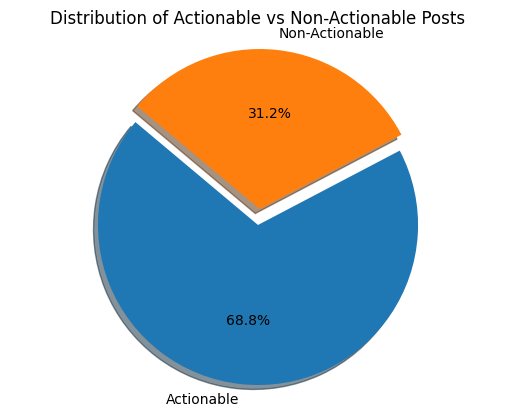

actionable_post(677): ['is awful ive taken online lesson class like 6 time ive built full video game scratch using class 300 line code literally never understood heck selfinit today lack trying ive tried understand many time working projectslearning class looked definition multiple time finally today writing 50th selfinit clicked optional initialize setting class music producer akin initial patch synthesizer except choose whether anything there but man extensive coding clicked me explanation help all people find happens lot way python explained', 'so im trying code game tic tac toe tie detected board change 5x5 computer player make final game winning move however currently computer replaces already made move give win instead making one last move idea why suggestion make board list tttboard populate board use method new game etc def makeboard specify want use global list create new local list global tttboard blank old board tttboard append number 1 9 new board range 110 tttboardappendi 

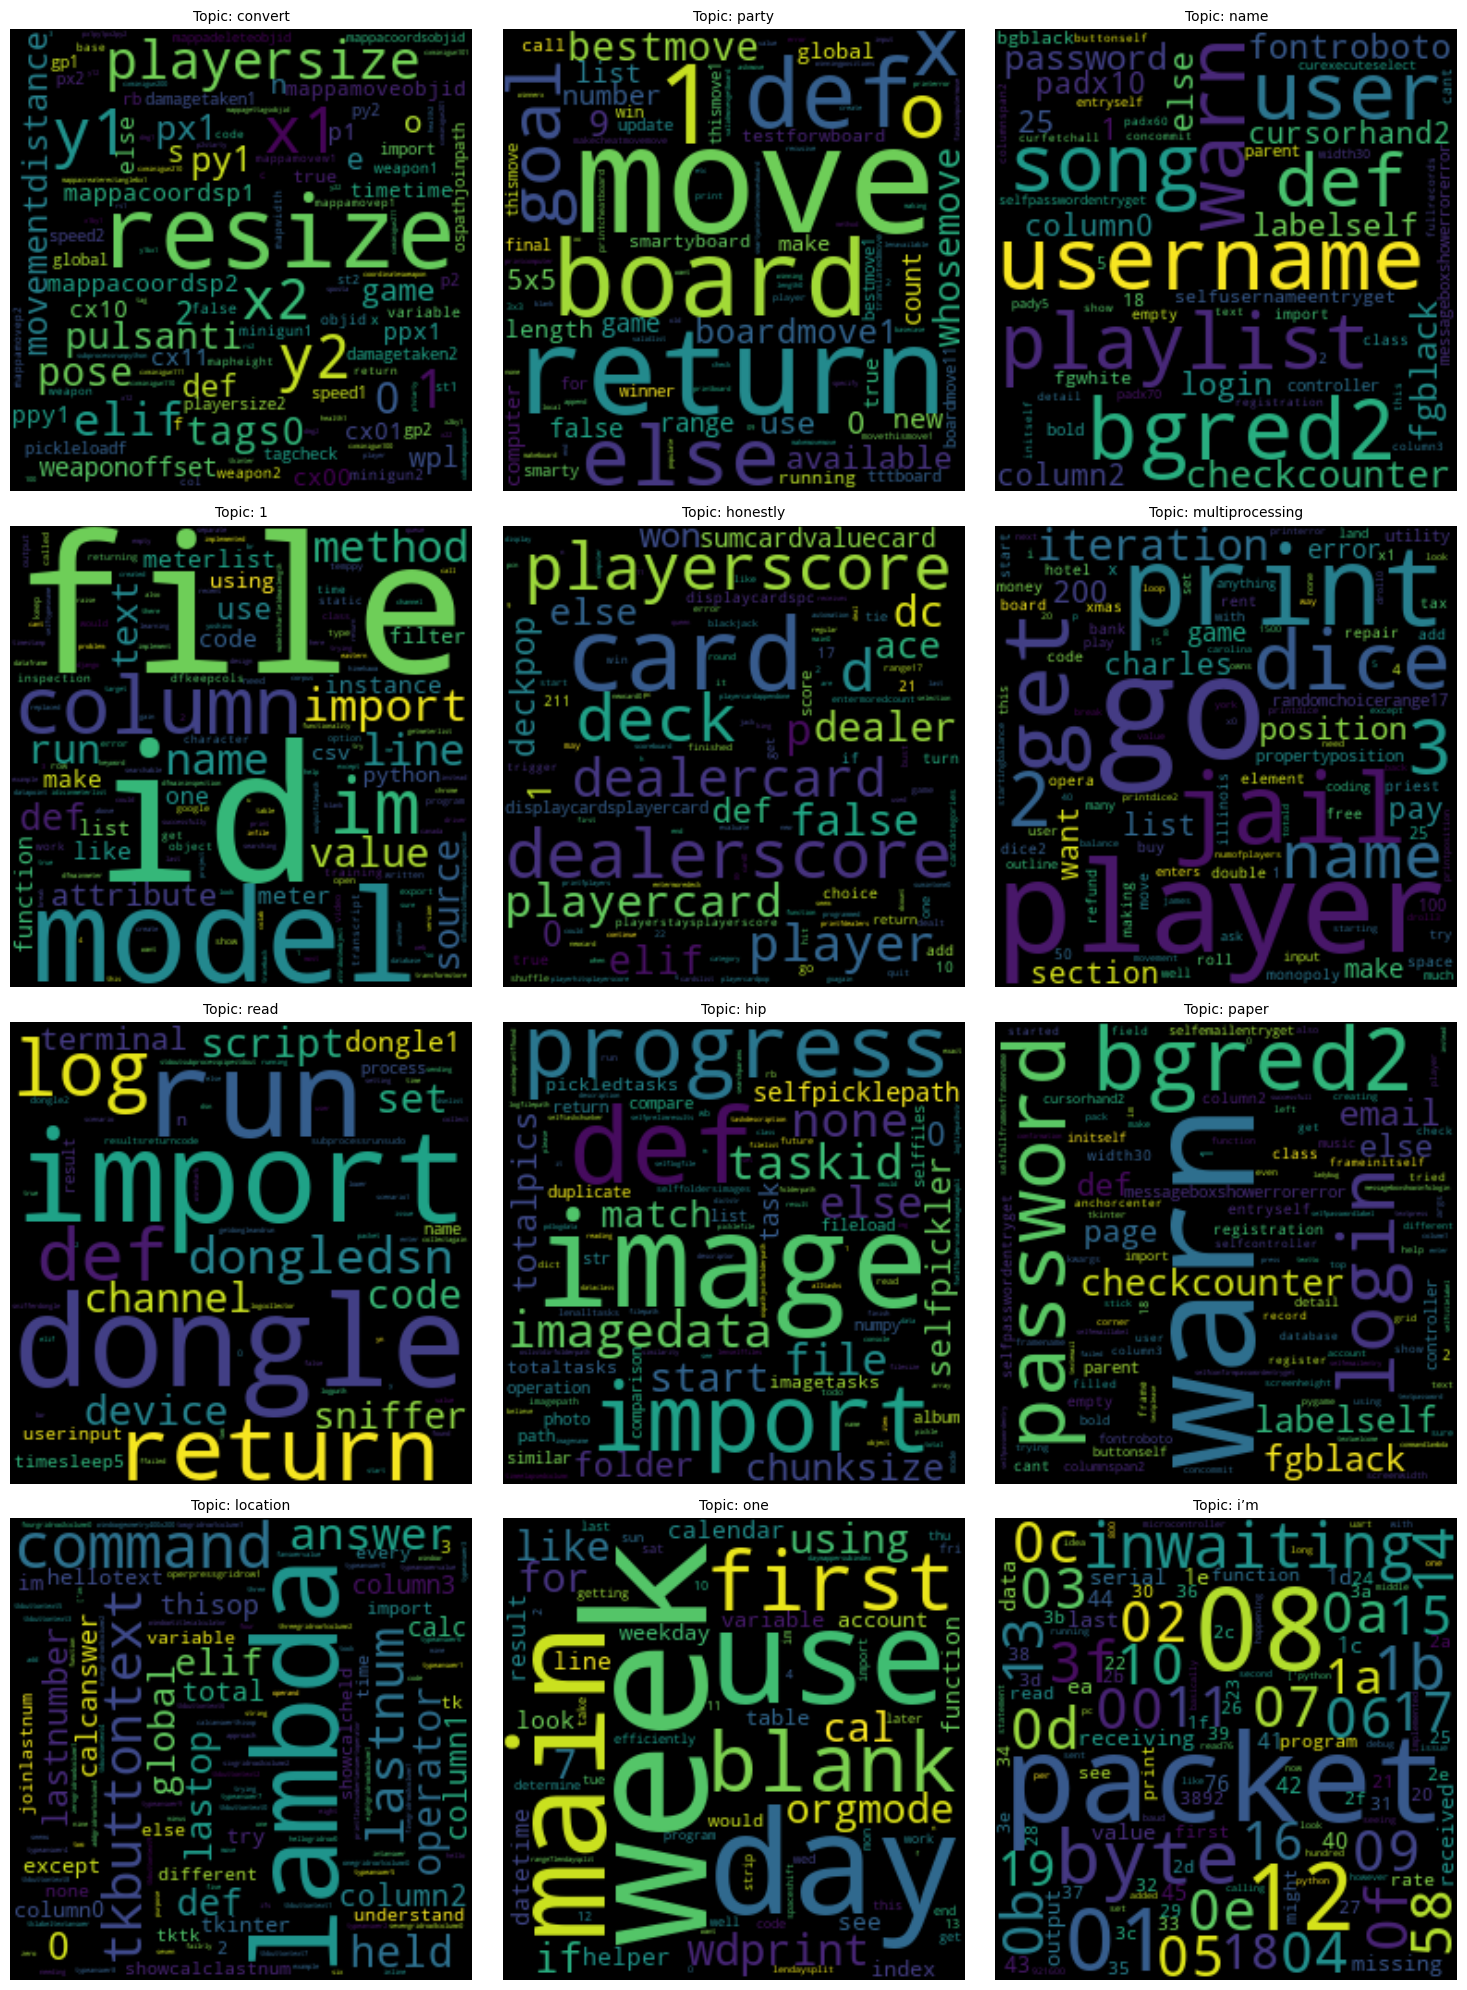

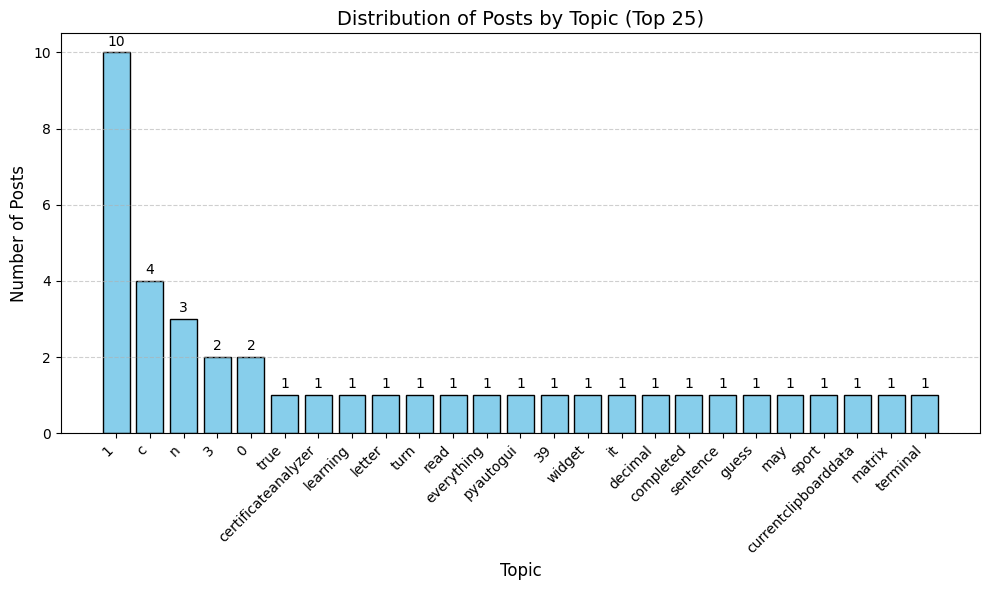

Completed!!


In [51]:
def __main__():
    post_list = collect_text_data()
    doc_clean = remove_noise(post_list)
    doc_standard = standardized_post(doc_clean)
    actionable_post = decide_actionable_post(doc_standard)
    topic_list = extract_topic_from_post(actionable_post)
    dict = group_by_topic_wise(topic_list, actionable_post)
    vis_wordcloud(dict, topic_list)
    vis_bargraph(dict)
    store_into_file(dict)
    print("Completed!!")

__main__()